In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import re

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from bopak.reprocess import albedo_db, iceage_db, onset_db,sic_db,sic_db_ease2, sic, onset, iceage, albedo, set_BOEASE2, ptproj, loc_ease2
from bopak.reprocess.test_year import test_year

## ONR Brighter Ocean annual report plotting notebook

In [4]:
# --- Load some data into the testyear object
yrs = [2012,2022]
albroot = Path('/data/BO/EASE2/albedo/V0.04')
ONSET_ROOT = Path('/data/BO/EASE2/onset/')
IA_ROOT = Path('/data/BO/EASE2/ICEAGE/V4')
SIC_REGRID = Path('/data/BO/EASE2/SIC')
test0 = test_year(yrs[0], alb_root=albroot, onset_root=ONSET_ROOT, ia_root=IA_ROOT,sic_root=SIC_REGRID)
test0.load_data()
test1 = test_year(yrs[1], alb_root=albroot, onset_root=ONSET_ROOT, ia_root=IA_ROOT,sic_root=SIC_REGRID)
test1.load_data()

/data/BO/EASE2/onset/2012731smeltfreeze.nc /data/BO/EASE2/ICEAGE/V4/iceage_nh_12.5km_20120101_20121231_v4.1.nc /data/BO/EASE2/albedo/V0.04/albedo_BO_2012_V0.04.nc
/data/BO/EASE2/onset/2022731smeltfreeze.nc /data/BO/EASE2/ICEAGE/V4/iceage_nh_12.5km_20220101_20221231_v4.1.nc /data/BO/EASE2/albedo/V0.04/albedo_BO_2022_V0.04.nc


In [13]:
# --- setup map projection, plotting grid, and color levels
pcproj = ccrs.PlateCarree()
mds, boprj = set_BOEASE2()
XLIM = mds.XLIM
YLIM = mds.YLIM
xx,yy = np.meshgrid(mds.X.values, mds.Y.values)

mlvl = levels=np.linspace(80,210,27)
flvl = levels=np.linspace(210,360,31)

### Load SIC data on the date of sea ice minimum of the two years

In [6]:
SIC_REGRID = Path('/data/BO/EASE2/SIC')

tt_sic = [pd.to_datetime(x) for x in ['2012-09-16','2022-09-18']]

tt_sic = ['2012-09-16','2022-09-18']
sicyr_df = sic_db_ease2(SIC_REGRID)
dat_sic = []
for iyr in range(2):
    fn = sicyr_df[sicyr_df.time.dt.year==yrs[iyr]].iloc[0].fn
    with xr.open_dataset(fn) as sic_ds:
        sic_ds.load()
    sic_ds = sic_ds.swap_dims(dict(tdim='time'))
    dat_sic.append(sic_ds['cdr_seaice_conc'].sel(time=tt_sic[iyr]))

In [7]:
def compare_onset(yrs,vns,tests,dat_sic,lon0,lat0,ftsz=16,):
    '''
    Setup a function to plot onset date comparisons. Move to test_year in future. 

    Parameters:
    ----------
    yrs: list of int. len(yrs) is 2. The two years to compare
    tests: list of testyear object. len(tests) is 2. The regridded onset data are loaded into them
    dat_sic: list of xr.DataArray. len(dat_sic) is 2. The sic data on the date of sic minimum of the two years
    lon0: int/float. Longitude of the point to plot albedo accordion.
    lat0: int/float. Latitude of the point to plot albedo accordion. 
    '''
    from cartopy.feature import OCEAN 
    from cartopy.feature import LAND
    chdls = []
    fig, axs = plt.subplots(2,2,figsize=(11,10),subplot_kw=dict(projection=boprj))
    for ivn,vn in enumerate(vns):
        lvls = mlvl if vn in ['Melt','Earlymelt'] else flvl
        for iyr,rdat in enumerate(tests):

            ax = axs[ivn,iyr]
            
            ax.set_extent([-XLIM,XLIM,-YLIM,YLIM],crs=boprj)
            ax.coastlines(color='.5')
            ax.gridlines(xlocs=np.linspace(-180,180,9))
            chdl = ax.contourf(xx,yy,rdat.onset[vn].values,cmap='RdBu_r',levels=lvls,extend='both')
            chdls.append(chdl)
            ax.add_feature(OCEAN,color='.8',alpha=.5)
            ax.add_feature(LAND,color='.6')
            txt_ttl = f'{yrs[iyr]}: {vn} onset date'
            ax.set_title(txt_ttl,fontsize=ftsz)
            ax.contour(xx,yy,dat_sic[iyr],levels=[.15],colors='k')
            ax.plot(lon0,lat0,'*',color='g',transform=pcproj)

            
    fig.subplots_adjust(wspace=-.1,hspace=.15,top=.95,bottom=.05,left=.05,right=.90)
    cax = fig.add_axes([.91,.53,.03,.42])
    fig.colorbar(chdls[0],ax=ax,cax=cax)
    cax = fig.add_axes([.91,.05,.03,.42])
    fig.colorbar(chdls[2],ax=ax,cax=cax)
    
    return fig, axs

### Plot comparison of Onset dates
* Melt and Freeze onset dates (later pair)
* Early melt and freeze onset dates (earlier pair)
* The 15% SIC contours are plotted in black
* The point to show the albedo accordion is plotted with a green star. Because of the missing early melt onset dates in 2012, the choice of location is not as many as expected. 

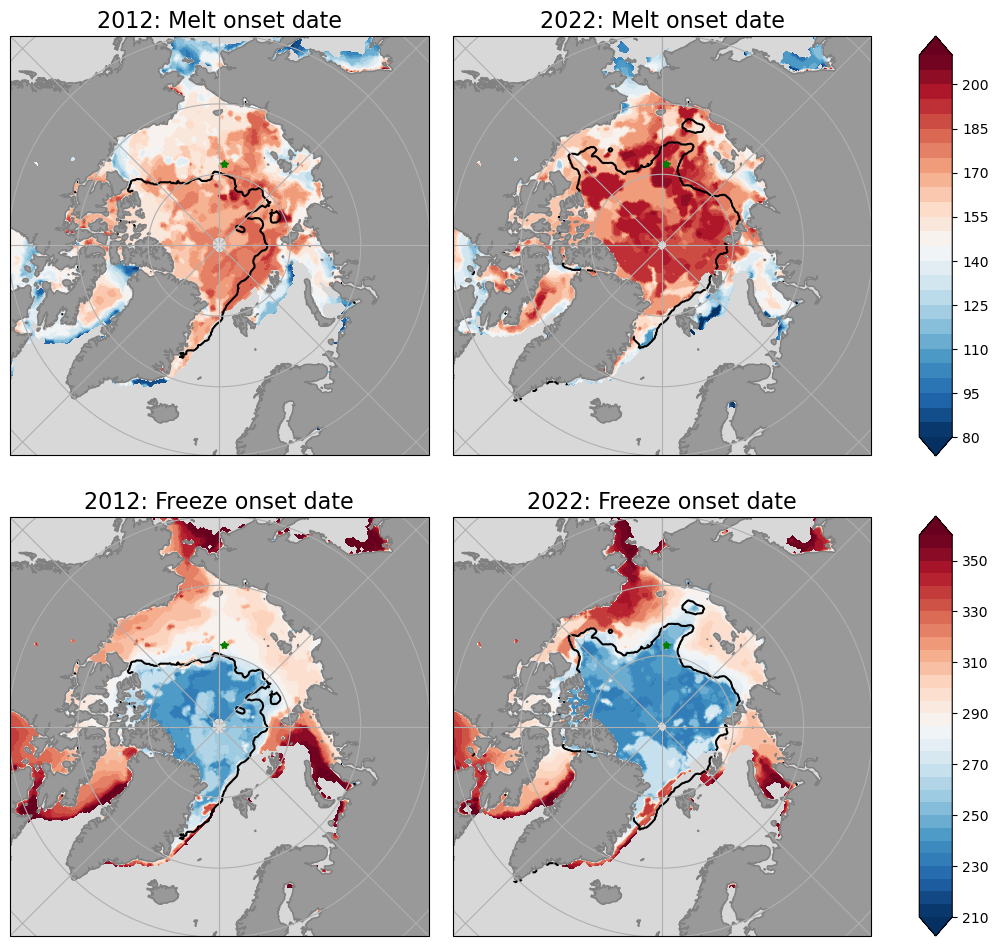

In [9]:
lat0 = 78.5
lon0 = 177
fig, axs = compare_onset(yrs,['Melt','Freeze'],[test0,test1],dat_sic,lon0=lon0,lat0=lat0)

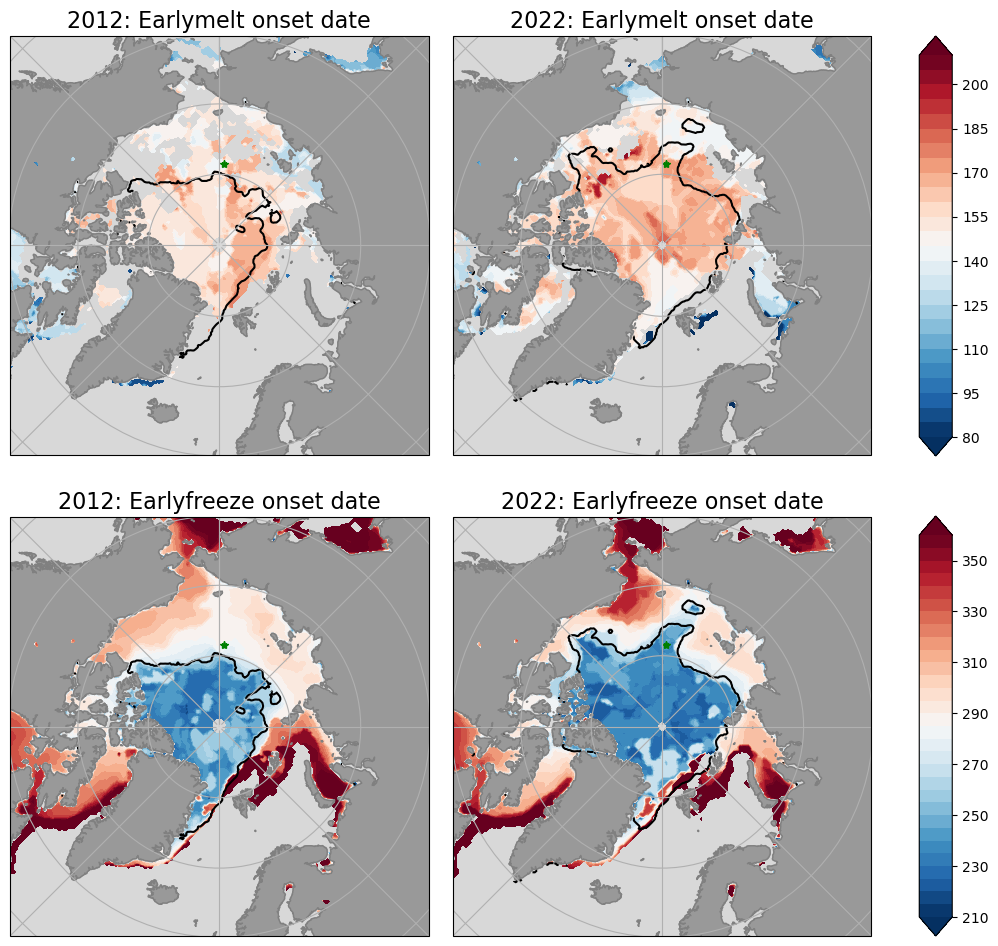

In [10]:
lat0 = 78.5
lon0 = 177
fig, axs = compare_onset(yrs,['Earlymelt','Earlyfreeze'],[test0,test1],dat_sic,lon0=lon0,lat0=lat0)

### Compare albedo accordion of the two years
* The SIC time series are added (megenta lines) as a reference. The SIC dataset is not the same one used by the IceAge retrievals, according to its documentation. But it seems there are still decent consistency even when they are regridded from two different grids. 

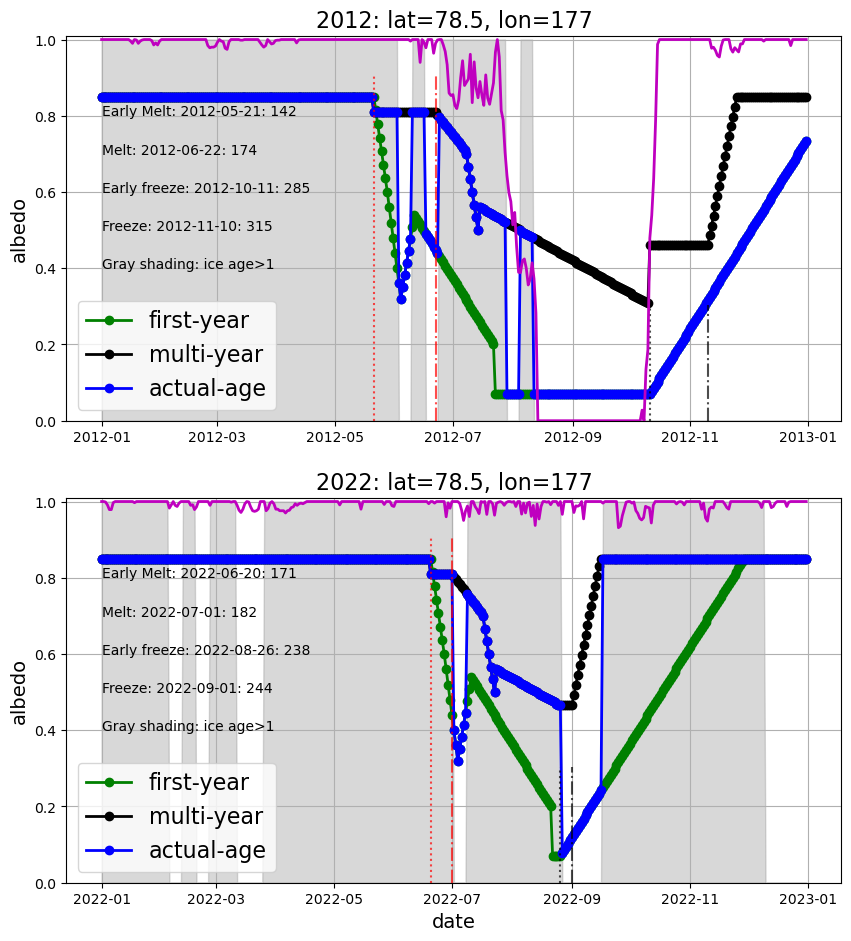

In [11]:
lon = lon0
lat = lat0
fig, axs = plt.subplots(2,1,figsize=(10,11),sharex=False)
fig,ax = test0.plot_accordion(*(lat,lon),
                              marker='o',ms=6,
                              fig=fig, ax=axs[0],add_sic=True,
                              add_xlabel=False,
                              )
fig,ax = test1.plot_accordion(*(lat,lon),
                              marker='o',ms=6,
                              fig=fig, ax=axs[1],
                              add_sic=True,
                              )